In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Maps
import folium

# Machine Learning 
import sklearn
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve

# Might need for pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

In [2]:
#Session info
import sys
print(sys.version)

[print(f'{lib.__name__} version {lib.__version__}') for lib in [pd, np, folium, sklearn]]

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
pandas version 0.23.4
numpy version 1.15.1
folium version 0.6.0
sklearn version 0.20.0


[None, None, None, None]

In [3]:
df_projects = pd.read_csv('./data/projects.csv')
df_outcomes = pd.read_csv('./data/outcomes.csv')
df_essays = pd.read_csv('./data/essays.csv')

In [4]:
def recode_tf_binary(df):
    """Recodes t/f to 0/1 dummies in anticipation of later ML models"""
    d = {'f':0, 't':1}
    for col in df.columns: 
        if all(val in ['f','t', np.nan] for val in df[col].unique().tolist()):
            df[col] = df[col].map(d)
    return df

In [5]:
df_outcomes = recode_tf_binary(df_outcomes)
df_projects = recode_tf_binary(df_projects)

In [6]:
df_projects.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted'],
      dtype='object')

In [7]:
df_outcomes.describe(include='all')

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
count,619326,619326.000000,524928.000000,619326.000000,524928.000000,619326.000000,524928.000000,524928.000000,524928.000000,439487.00000,524928.000000,524928.000000
unique,619326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,b840ee0136c78e150e21b9abd97182ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.059274,0.237480,0.695406,0.721419,0.302216,0.518886,0.719735,0.013213,52.92709,0.777339,4.361290
std,NaN,0.236137,0.425539,0.460236,0.448301,0.459219,0.499644,0.449129,0.114187,35.71410,2.227933,5.668748
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.00000,0.000000,1.000000
50%,NaN,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,50.00000,0.000000,3.000000
75%,NaN,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,83.00000,0.000000,5.000000


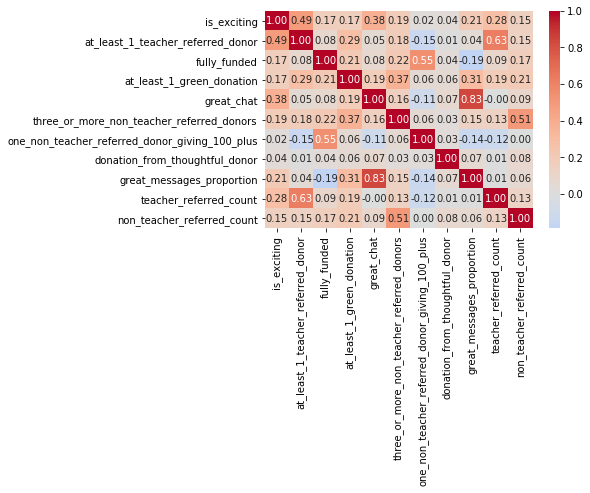

In [8]:
corr = df_outcomes.drop(columns='projectid').corr()
g = sns.heatmap(corr, annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

In [9]:
corr.fully_funded.sort_values(ascending=False)

fully_funded                                      1.000000
one_non_teacher_referred_donor_giving_100_plus    0.547017
three_or_more_non_teacher_referred_donors         0.218347
at_least_1_green_donation                         0.214017
is_exciting                                       0.166128
non_teacher_referred_count                        0.165221
teacher_referred_count                            0.093554
at_least_1_teacher_referred_donor                 0.079961
great_chat                                        0.079323
donation_from_thoughtful_donor                    0.036309
great_messages_proportion                        -0.188422
Name: fully_funded, dtype: float64

In [10]:
df_projects.shape

(664098, 35)

In [11]:
df_outcomes.shape

(619326, 12)

In [12]:
outcome = 'fully_funded'

In [13]:
df_essays.drop('teacher_acctid', axis = 1, inplace=True) #also in df_projets
data = pd.merge(df_essays, df_projects, on = 'projectid')
df = pd.merge(data, df_outcomes[['projectid', outcome]])
df.shape

(619326, 40)

# Examine Bivariate Relationships between predictors and outcome

In [14]:
outcome = 'fully_funded'

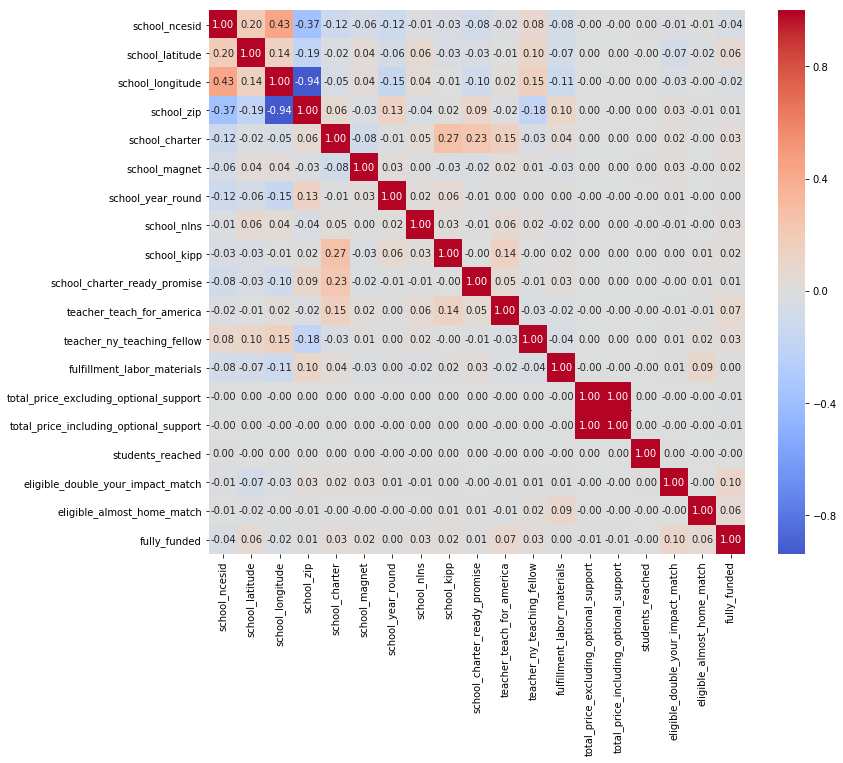

In [15]:
cols = df.select_dtypes(exclude='O').columns
corr = df[cols].corr()
plt.figure(figsize=[12,10])
g = sns.heatmap(corr,annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

In [16]:
corr['fully_funded'].sort_values(ascending=False)

fully_funded                              1.000000
eligible_double_your_impact_match         0.097188
teacher_teach_for_america                 0.069738
school_latitude                           0.061257
eligible_almost_home_match                0.055720
teacher_ny_teaching_fellow                0.032863
school_charter                            0.032069
school_nlns                               0.025048
school_magnet                             0.018631
school_kipp                               0.018457
school_charter_ready_promise              0.013466
school_zip                                0.006217
fulfillment_labor_materials               0.004677
school_year_round                         0.001255
students_reached                         -0.002840
total_price_including_optional_support   -0.009418
total_price_excluding_optional_support   -0.009551
school_longitude                         -0.023831
school_ncesid                            -0.038652
Name: fully_funded, dtype: floa

In [17]:
#Price per student
df['price_per_student'] = df.total_price_including_optional_support / df.students_reached
# NOTE - different ways to impute price per student when students_reached is 0
# could either divide by median students, or leave missing. I'll try the former for now
median_students = df[df.students_reached > 0].students_reached.median()
df.loc[df.students_reached == 0, 'price_per_student'] = df.total_price_including_optional_support / median_students

expensive_projects = (df.students_reached > 0) & (df.price_per_student > 1000)
print(df[expensive_projects][outcome].count())
print(df[expensive_projects][outcome].mean())

271
0.4022140221402214


In [18]:
df[expensive_projects][['fully_funded', 'title', 'short_description', 
                        'students_reached', 'total_price_including_optional_support']].head()

,fully_funded,title,short_description,students_reached,total_price_including_optional_support
1412,1,Trip to France,We would appreciate your support for this stud...,1.0,2440.00
1825,1,Laptop to Enable Student to Produce Written Work,I am submitting a proposal for a laptop with s...,1.0,1181.71
3654,1,France and Spain Educational Tour,I want to change the way our world language st...,6.0,12054.09
5341,0,Help An Immigrant Student Work His Way Towards...,I truly believe that having a laptop to use in...,1.0,2284.15
5708,1,Help Me Go to Harvard Part 3,I began teaching the most amazing students thr...,1.0,1021.95


In [19]:
#VERY expensive
df[(df.students_reached > 0) & (df.price_per_student > 10000)][['fully_funded', 'title', 'short_description']].head()

,fully_funded,title,short_description
139070,0,fkjghoignjg,fnli uglzbgf uigl fn liuglz bgfu igl fnli uglz...
273672,0,TEST - PLEASE DO NOT DONATE,NaN
313431,1,Urgent Reading Intervention Needed!,"Just imagine what it feels like to be sixteen,..."
613975,1,Give Cindy a Voice,"Cindy is very bright. She is patient, kind an..."


In [20]:
def plot_continuous_var(var, df= df, nobs = 20_000, max_val = np.inf):
    """Plots continuous variable, subsetting nobs for speed"""
    ax = sns.regplot(x=var, y=outcome, data=df.iloc[:nobs].query(f'{var} < {max_val}'), lowess=True, y_jitter=.03) 

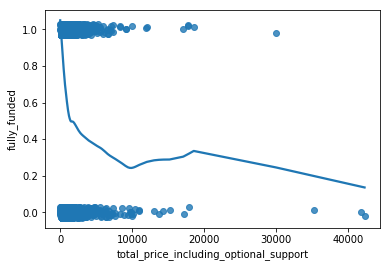

In [21]:
plot_continuous_var('total_price_including_optional_support')

In [22]:
def plot_categorical_var(varname, df=df, n=100_000, height=4):
    """Plots categorical variable, subsetting nobs for speed"""
    g = sns.catplot(varname,data=df[:n],kind="count", height=height)
    g.set_xticklabels(rotation=90)
    g = sns.catplot(x=varname,y=outcome,data=df[:n],kind="bar", height=height)
    g.set_xticklabels(rotation=90)

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


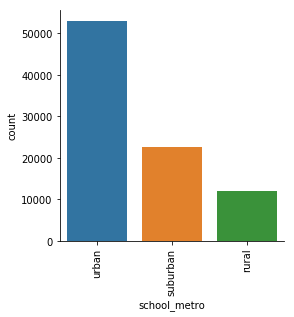

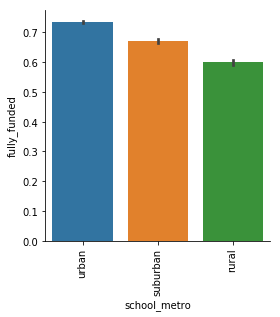

In [23]:
plot_categorical_var('school_metro')

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


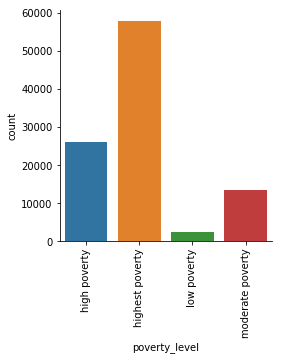

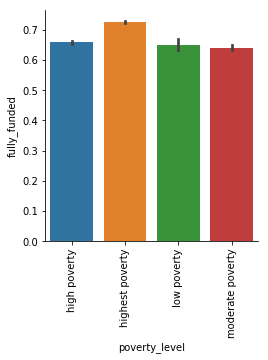

In [24]:
plot_categorical_var('poverty_level')

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


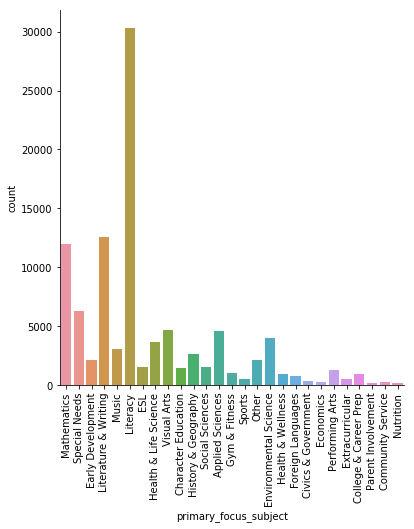

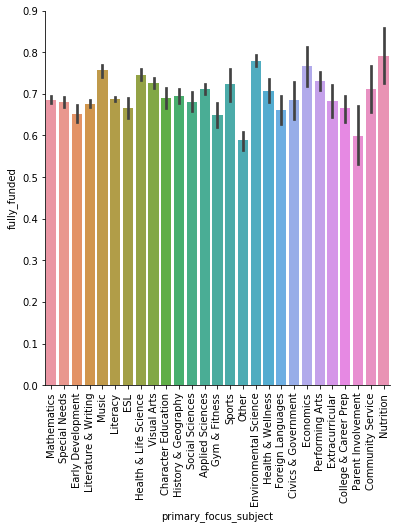

In [25]:
plot_categorical_var('primary_focus_subject', height=6)

# Temporal Trends
Interestingly, there seem to be seasonal fluctuations in funding patterns. Given the school year, it makes sense that many projects are posted in the fall, though it is unclear why those in the fall tend to have 10% higher success rate than those in the spring. 
The number of projects posted has drastically increased each year. Success rate dropped during the first few years, but since has remained somewhat constant since 2005.

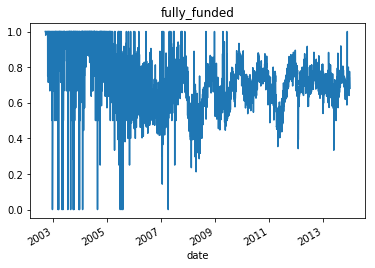

In [26]:
df['date'] = pd.to_datetime(df.date_posted)
def plot_var_over_time(varname, df = df):
    ts = df.groupby(['date'])[varname].mean() #.reset_index()
    ts.plot(title=varname)
plot_var_over_time(outcome)

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


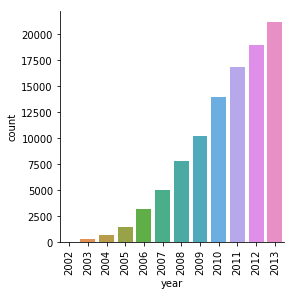

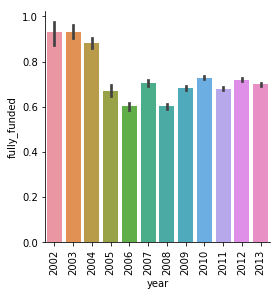

In [27]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
plot_categorical_var('year')

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


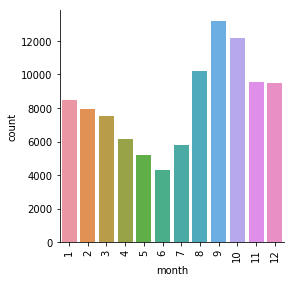

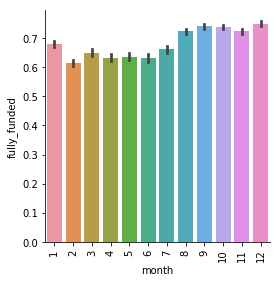

In [28]:
plot_categorical_var('month')

# Split data into training and testing
To simulate a real world problem, I'll use the last year of data as the test data, and only use old data to train the model. This may decrease accuracy but will increase generalizability

In [29]:
cols_to_keep = [
    'school_latitude', 'school_longitude',
    'school_state', 'school_zip',
    'school_metro', 'school_charter', 'school_magnet', 
    'school_year_round', 'school_nlns', 'school_kipp',
    'school_charter_ready_promise', 'teacher_prefix',
    'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
   'primary_focus_subject', 'primary_focus_area',
   'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
   'poverty_level', 'grade_level', 'fulfillment_labor_materials',
   'total_price_excluding_optional_support',
   'total_price_including_optional_support', 'students_reached',
   'eligible_double_your_impact_match', 'eligible_almost_home_match',
   'price_per_student', 'month', 'year'
               ]

cols_to_drop = [
    'projectid',  # unique identifier
    'title', 'short_description', 'need_statement', 'essay',  # could do NLP later
    'teacher_acctid', 'schoolid', 'school_ncesid', 'school_city', 'school_district', 'school_county',  # could try using these identifiers later
    'date', 'date_posted',  # has already had month and year extracted
]

# Make sure I didn't forget any columns
assert all([col in cols_to_keep + cols_to_drop] for col in df.columns)

In [30]:
# DEVELOPMENT HACK
cols_to_keep = [
    'school_metro', 'school_charter', 'school_magnet', 
    'school_year_round', 'school_nlns', 'school_kipp',
    'school_charter_ready_promise', 'teacher_prefix',
    'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
    'total_price_including_optional_support', 'year', 'students_reached',
   'eligible_double_your_impact_match', 'eligible_almost_home_match',
    'poverty_level', 'grade_level'
]

In [31]:
df_test = df.query('year == 2013')
df_train = df.query('year < 2013')
X = df_train[cols_to_keep]
y = df_train[outcome]

In [32]:
# TEMP - subset for training
X = X[:100_000]
y = y[:100_000]

In [33]:
kfold = StratifiedKFold(n_splits=5, random_state=0)

In [34]:
def pipeline_cv_score(model_pipeline, X, y):
    """Display cross-validation score of a pipeline given data X and y"""
    cv_score = cross_val_score(model_pipeline, X, y, cv=kfold, n_jobs=1)
    print(f'Cross Validation Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [35]:
class DataFrameImputer(TransformerMixin):
    """Adatped from https://stackoverflow.com/questions/934616/how-do-i-find-out-if-a-numpy-array-contains-integers"""
    
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):
        
        self.fill = pd.Series([self.impute_series(X[c]) for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

    def impute_series(self, series):
        """Determines which statistic to use given data type"""
        if series.dtype == np.dtype('O'):
            return series.value_counts().index[0]
        elif issubclass(series.dtype.type, np.float):
            return series.mean()
        elif issubclass(series.dtype.type, np.integer):
            return series.median()
        else: 
            raise AssertionError(f'{series.dtype} not recognized')

# Pipeline

In [687]:
from sklearn.base import BaseEstimator
class BasicTransformer(BaseEstimator):
    """
    Does imputation, one-hot encoding, and scaling of features with option of return pd.DataFrame
    WARNING: currently, it's a flawed implementation (e.g, does things like imputing test mean rather
    than using a mean return by fit method)
    Adapted from 
    https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62
    """
    
    
    def __init__(self, cat_threshold=None, num_strategy='median',
                 return_df=False):
        # store parameters as public attributes
        self.cat_threshold = cat_threshold
        
        if num_strategy not in ['mean', 'median']:
            raise ValueError('num_strategy must be either "mean" or "median"')
        self.num_strategy = num_strategy
        self.return_df = return_df
        
    def fit(self, X, y=None):
        # Assumes X is a DataFrame
        self._columns = X.columns.values
        
        # Split data into categorical and numeric
        self._dtypes = X.dtypes.values
        self._kinds = np.array([dt.kind for dt in X.dtypes])
        self._column_dtypes = {}
        is_cat = self._kinds == 'O'
        self._column_dtypes['cat'] = self._columns[is_cat]
        self._column_dtypes['num'] = self._columns[~is_cat]
        self._feature_names = self._column_dtypes['num']
        
        # Create a dictionary mapping categorical column to unique 
        # values above threshold
        self._cat_cols = {}
        for col in self._column_dtypes['cat']:
            vc = X[col].value_counts()
            if self.cat_threshold is not None:
                vc = vc[vc > self.cat_threshold]
            vals = vc.index.values
            self._cat_cols[col] = vals
            self._feature_names = np.append(self._feature_names, col 
                                            + '_' + vals)
            
        # get total number of new categorical columns    
        self._total_cat_cols = sum([len(v) for col, v in 
                                    self._cat_cols.items()])
        
        # get mean or median
        num_cols = self._column_dtypes['num']
        self._num_fill = X[num_cols].agg(self.num_strategy)
        return self
        
    def transform(self, X):
        # check that we have a DataFrame with same column names as 
        # the one we fit
        if set(self._columns) != set(X.columns):
            raise ValueError('Passed DataFrame has different columns than fit DataFrame')
        elif len(self._columns) != len(X.columns):
            raise ValueError('Passed DataFrame has different number of columns than fit DataFrame')
            
        # fill missing values
        num_cols = self._column_dtypes['num']
        X_num = X[num_cols].fillna(self._num_fill)
        
        # Standardize numerics
        std = X_num.std()
        X_num = (X_num - X_num.mean()) / std
        zero_std = np.where(std == 0)[0]
        
        # If there is 0 standard deviation, then all values are the 
        # same. Set them to 0.
        if len(zero_std) > 0:
            X_num.iloc[:, zero_std] = 0
        X_num = X_num.values
        
        # create separate array for new encoded categoricals
        X_cat = np.empty((len(X), self._total_cat_cols), 
                         dtype='int')
        i = 0
        for col in self._column_dtypes['cat']:
            vals = self._cat_cols[col]
            for val in vals:
                X_cat[:, i] = X[col] == val
                i += 1
                
        # concatenate transformed numeric and categorical arrays
        data = np.column_stack((X_num, X_cat))
        
        # return either a DataFrame or an array
        if self.return_df:
            return pd.DataFrame(data=data, 
                                columns=self._feature_names)
        else:
            return data
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    
    def get_feature_names(self):
        return self._feature_names

In [590]:
X.shape

(100000, 17)

In [609]:
transformer = BasicTransformer(return_df=True)
X_transformed = transformer.fit_transform(X)

In [600]:
X_transformed.shape

(100000, 28)

In [610]:
X_transformed.head()

,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_including_optional_support,year,...,teacher_prefix_Mr.,teacher_prefix_Dr.,poverty_level_highest poverty,poverty_level_high poverty,poverty_level_moderate poverty,poverty_level_low poverty,grade_level_Grades PreK-2,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12
0,-0.303571,-0.330268,-0.23411,-0.133032,-0.084622,-0.077301,-0.259188,-0.14282,0.133763,-0.413045,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.303571,-0.330268,-0.23411,-0.133032,-0.084622,-0.077301,-0.259188,-0.14282,-0.186666,0.590430,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.303571,3.027817,-0.23411,-0.133032,-0.084622,-0.077301,-0.259188,-0.14282,-0.043799,0.088692,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.303571,-0.330268,-0.23411,-0.133032,-0.084622,-0.077301,-0.259188,-0.14282,0.194581,-0.413045,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.303571,-0.330268,-0.23411,-0.133032,-0.084622,-0.077301,-0.259188,-0.14282,0.175675,1.092167,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [611]:
classifier = ('rf', RandomForestClassifier())
pipeline = Pipeline([('transformer', transformer), classifier])

In [605]:
cross_val_score(pipeline, X, y, cv=kfold).mean()

0.6552397213055492

In [618]:
X_transformed.columns

Index(['school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'total_price_including_optional_support', 'year', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'school_metro_urban', 'school_metro_suburban', 'school_metro_rural',
       'teacher_prefix_Mrs.', 'teacher_prefix_Ms.', 'teacher_prefix_Mr.',
       'teacher_prefix_Dr.', 'poverty_level_highest poverty',
       'poverty_level_high poverty', 'poverty_level_moderate poverty',
       'poverty_level_low poverty', 'grade_level_Grades PreK-2',
       'grade_level_Grades 3-5', 'grade_level_Grades 6-8',
       'grade_level_Grades 9-12'],
      dtype='object')

In [623]:
classifier[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [627]:
X_perm = X_transformed[['school_magnet', 'school_charter']]

model = classifier[1].fit(X_transformed, y)
perm = PermutationImportance(model, random_state=0).fit(X_transformed, y)
eli5.show_weights(perm, feature_names = X_transformed.columns.tolist())

Weight,Feature
0.3234 ± 0.0032,total_price_including_optional_support
0.2155 ± 0.0012,year
0.1935 ± 0.0023,students_reached
0.1238 ± 0.0018,eligible_double_your_impact_match
0.1212 ± 0.0009,school_metro_urban
0.0829 ± 0.0006,poverty_level_highest poverty
0.0811 ± 0.0012,teacher_prefix_Mrs.
0.0599 ± 0.0008,school_metro_suburban
0.0587 ± 0.0004,teacher_prefix_Ms.
0.0550 ± 0.0008,grade_level_Grades PreK-2


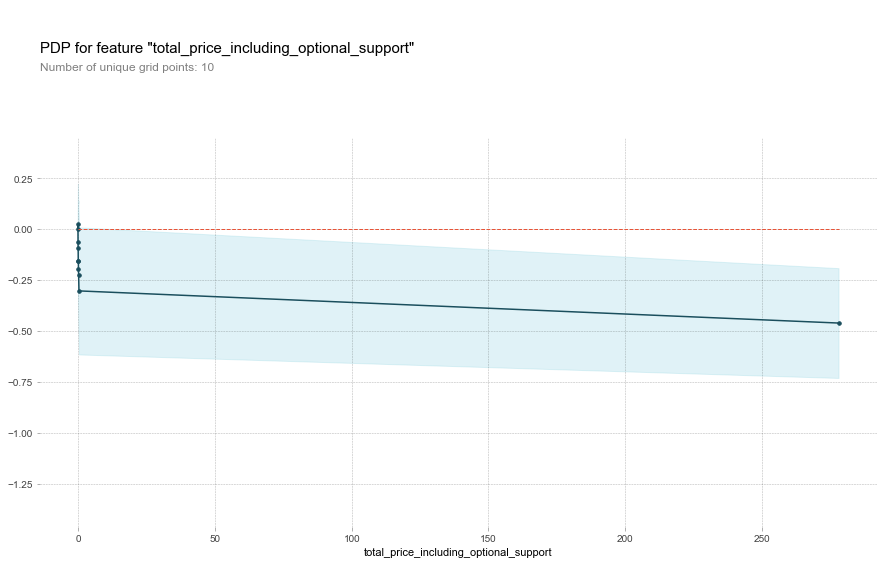

In [628]:
pdp_tempmax = pdp.pdp_isolate(model, dataset=X_transformed, model_features=X_transformed.columns.tolist(), feature='total_price_including_optional_support')
pdp.pdp_plot(pdp_tempmax, 'total_price_including_optional_support')
plt.show()

In [634]:
data_for_prediction

school_charter                           -0.303571
school_magnet                            -0.330268
school_year_round                        -0.234110
school_nlns                              -0.133032
school_kipp                              -0.084622
school_charter_ready_promise             -0.077301
teacher_teach_for_america                -0.259188
teacher_ny_teaching_fellow               -0.142820
total_price_including_optional_support    0.241813
year                                      1.092167
students_reached                         -0.163667
eligible_double_your_impact_match        -0.622400
eligible_almost_home_match               -0.276284
school_metro_urban                        1.000000
school_metro_suburban                     0.000000
school_metro_rural                        0.000000
teacher_prefix_Mrs.                       1.000000
teacher_prefix_Ms.                        0.000000
teacher_prefix_Mr.                        0.000000
teacher_prefix_Dr.             

In [637]:
row_to_show = 1
data_for_prediction = X_transformed.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

model.predict(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

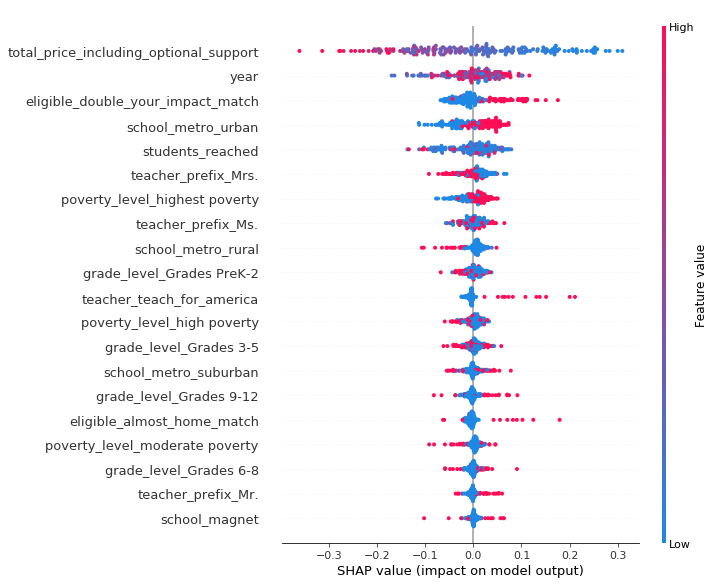

In [639]:
val_X_subset = X_transformed.sample(200, random_state=42)
shap_values = explainer.shap_values(val_X_subset)
shap.summary_plot(shap_values[1], val_X_subset)

## Use sklearn ColumnTransformer pipeline, and get feature names afterward

In [113]:
num_cols = X.select_dtypes('integer').columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step] #num_ss_step 
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
# cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))  # seems way slower
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_cols)]

transformers = [('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)
classifier = RandomForestClassifier(max_depth=16, n_estimators=20, random_state=42)
pipeline = Pipeline([('transformer', ct), ('classifier', classifier)])


X_transformed = ct.fit_transform(X)

In [114]:
cross_val_score(pipeline, X, y, cv=kfold).mean()

0.6867900043741499

In [83]:
X_transformed.shape

(100000, 26)

In [84]:
def rename_features(feature_list, old, new):
    return [f.replace(old, new) for f in feature_list]
    
def rename_ohe_features(ohe_feature_list, column_names):
    """
    Utility function to add original feature names after sklearn OneHotEncoder
    e.g. if 'myfeature' is encoded, it gives ['x0_cat1', 'x0_cat2']
    rename_ohe_features(['x0_cat1', 'x0_cat2'], 'myfeature') 
    returns ['myfeature_cat1', 'myfeature_cat2']
    """
    for i, col in enumerate(column_names):
        ohe_feature_list = rename_features(ohe_feature_list, f'x{i}', col)
    return ohe_feature_list

In [107]:
# Get the feature names (as they are mangled during sklearn OneHotEncoder)
ohe_feature_list = list(ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names())
cat_features = rename_ohe_features(ohe_feature_list, cat_cols)

In [108]:
# Get a pd.DataFrame with the feature names 
df_transformed = pd.DataFrame(X_transformed, columns=cat_features + num_cols)

In [115]:
classifier.fit(df_transformed, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [105]:
import shap

row_to_show = 1
data_for_prediction = df_transformed.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(classifier)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

classifier.predict(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

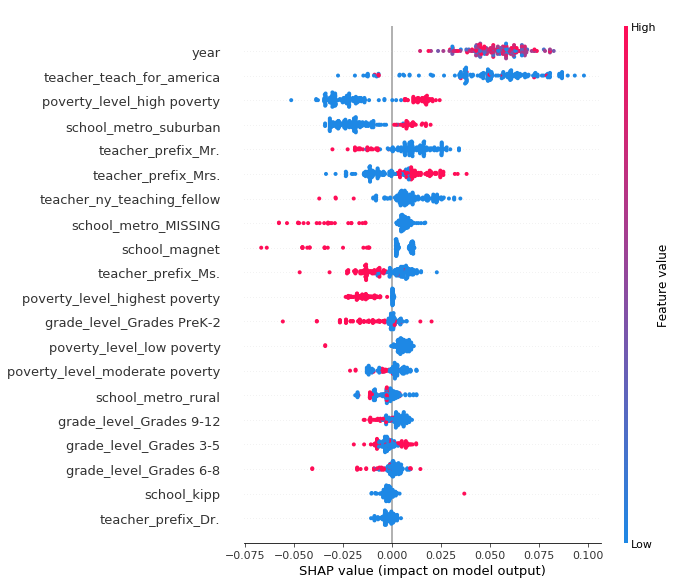

In [110]:
df_subset = df_transformed.sample(200, random_state=42)
shap_values = explainer.shap_values(df_subset)
shap.summary_plot(shap_values[1], df_subset)

Wall time: 24.1 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

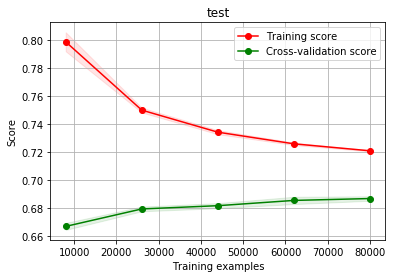

In [116]:
%%time
plot_learning_curve(pipeline, 'test', X, y, cv=kfold, n_jobs=1)

In [703]:
len(num_cols)

11

In [715]:
cat_features

['x0_MISSING',
 'x0_rural',
 'x0_suburban',
 'x0_urban',
 'x1_Dr.',
 'x1_Mr.',
 'x1_Mrs.',
 'x1_Ms.',
 'x2_high poverty',
 'x2_highest poverty',
 'x2_low poverty',
 'x2_moderate poverty',
 'x3_Grades 3-5',
 'x3_Grades 6-8',
 'x3_Grades 9-12',
 'x3_Grades PreK-2',
 'x3_MISSING']

In [716]:
cat_cols

['school_metro', 'teacher_prefix', 'poverty_level', 'grade_level']

In [ ]:
## Can I get column names from sklearn? 

In [642]:
num_cols = X.select_dtypes('integer').columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=num_transformers)
X_num_transformed = ct.fit_transform(X)
X_num_transformed.shape

(100000, 11)

In [655]:
cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

In [664]:
X_cat_transformed = cat_si_step[1].fit_transform(X)
X_cat_transformed.shape

(100000, 17)

In [685]:
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohc.fit_transform(X[['school_metro']].dropna())
ct = ColumnTransformer(transformers=[('ohe', ohc)])
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)
ct.fit_transform(X.dropna())

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [677]:
ct.get_feature_names()

AttributeError: Transformer cat (type Pipeline) does not provide get_feature_names.

In [686]:
ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names()

array(['x0_rural', 'x0_suburban', 'x0_urban', 'x1_Dr.', 'x1_Mr.',
       'x1_Mrs.', 'x1_Ms.', 'x2_high poverty', 'x2_highest poverty',
       'x2_low poverty', 'x2_moderate poverty', 'x3_Grades 3-5',
       'x3_Grades 6-8', 'x3_Grades 9-12', 'x3_Grades PreK-2'],
      dtype=object)

In [670]:
ohc.get_feature_names()

array(['x0_rural', 'x0_suburban', 'x0_urban'], dtype=object)

In [659]:
ct.get_feature_names()

AttributeError: Transformer cat (type Pipeline) does not provide get_feature_names.

In [661]:
debug

> c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\compose\_column_transformer.py(339)get_feature_names()
    337                 raise AttributeError("Transformer %s (type %s) does not "
    338                                      "provide get_feature_names."
--> 339                                      % (str(name), type(trans).__name__))
    340             feature_names.extend([name + "__" + f for f in
    341                                   trans.get_feature_names()])

ipdb> ll
    319     def get_feature_names(self):
    320         """Get feature names from all transformers.
    321 
    322         Returns
    323         -------
    324         feature_names : list of strings
    325             Names of the features produced by transform.
    326         """
    327         check_is_fitted(self, 'transformers_')
    328         feature_names = []
    329         for name, trans, _, _ in self._iter(fitted=True):
    330             i

In [660]:
dir(ct)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_columns',
 '_fit_transform',
 '_get_param_names',
 '_get_params',
 '_hstack',
 '_iter',
 '_remainder',
 '_replace_estimator',
 '_set_params',
 '_transformers',
 '_update_fitted_transformers',
 '_validate_column_callables',
 '_validate_names',
 '_validate_output',
 '_validate_remainder',
 '_validate_transformers',
 'fit',
 'fit_transform',
 'get_feature_names',
 'get_params',
 'n_jobs',
 'named_transformers_',
 'remainder',
 'set_params',
 'sparse_output_',
 'sparse_threshold',
 'transform',
 'transformer_weights',
 'transformers',
 'transformers_']

In [647]:
impt = num_si_step[1].fit(X[''])
impt._get_feature_names()

AttributeError: 'DataFrame' object has no attribute 'dtype'

# First Model - Random Forest

In [310]:
kfold = StratifiedKFold(n_splits=5, random_state=0)

clf = RandomForestClassifier(random_state=0)
pipeline = Pipeline(steps=[('imputer', DataFrameImputer()),
                           ('encoder', OneHotEncoder()),
                            ('feature_scaler', StandardScaler()),
                            ('model', RandomForestClassifier(random_state=0))])

In [224]:
# https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

In [449]:
categorical_feature_mask = [not issubclass(X[c].dtypes.type, np.float) for c in X.columns]

# Note: ColumnTransformer (new in sklearn 0.20) lets you do some operations that 
# previously I would have used FeatureUnion to do
ct = ('ct',ColumnTransformer([('oh_enc', OneHotEncoder(sparse=False),
                               categorical_feature_mask),], remainder='passthrough'))

ct = ('ct',ColumnTransformer([('label_enc', LabelEncoder(), categorical_feature_mask),
                             ('oh_enc', OneHotEncoder(sparse=False), categorical_feature_mask)], 
                             remainder='passthrough'))


pipeline = Pipeline(steps=[('imputer', DataFrameImputer()),
                           ct,
#                            ('feature_scaler', StandardScaler()),
                          ])

In [436]:
categorical_feature_mask

[False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True]

In [435]:
X.columns

Index(['school_latitude', 'school_longitude', 'school_state', 'school_zip',
       'school_metro', 'school_charter', 'school_magnet', 'school_year_round',
       'school_nlns', 'school_kipp', 'school_charter_ready_promise',
       'teacher_prefix', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'price_per_student', 'month', 'year'],
      dtype='object')

In [450]:
X_transformed = pipeline.fit_transform(X)

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [434]:
X_transformed[:1]

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0,
        0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,
        0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [402]:
for c in X.columns:
    if issubclass(X[c].dtype.type, np.float):
        print(c)

school_latitude
school_longitude
school_zip
fulfillment_labor_materials
total_price_excluding_optional_support
total_price_including_optional_support
students_reached
price_per_student


In [418]:
# from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

In [344]:
OneHotEncoder?

In [341]:
X.school_latitude.dtype

dtype('float64')

In [340]:
enc = OneHotEncoder()
test = enc.fit_transform(X[['school_latitude', 'school_longitude']])

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ValueError: X needs to contain only non-negative integers.

In [443]:
pipeline = Pipeline(steps=[('imputer', DataFrameImputer()),
                           ('encoder', OneHotEncoder(sparse=False)),
                          ])

In [438]:
cols = [issubclass(X[c].dtypes.type, np.float) for c in X.columns]
X_test = X.loc[:,cols]
X_test.shape

(10000, 8)

In [439]:
X_test = X.select_dtypes('O')
X_test.shape

(10000, 10)

In [444]:
X_transformed = pipeline.fit_transform(X_test)

In [446]:
X_transformed.shape

(10000, 139)

In [448]:
X_test[:1]

,school_state,school_metro,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level
0,SC,urban,Mrs.,Mathematics,Math & Science,Mathematics,Math & Science,Technology,high poverty,Grades 3-5


In [447]:
X_transformed[:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

## Define the problem: 
OneHotEncoder is working fine for objects (strings) alone, but when used with a categoricalfeaturemask or within ColumnTransformer, it gets unhappy

## Possible solutions
- Use LabelEncoder within ColumnTransformer so that maybe OneHotEncoder won't mangle strings. This shouldn't be necessary 
- Do a FeatureUnion for more fine-grain control 

In [455]:

class DataFrameSelector(TransformerMixin): # do I need BaseEstimator?
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [460]:
from sklearn.pipeline import FeatureUnion

In [563]:
binary_features = [c for c in X.columns if len(X[c].unique()) == 2]
numeric_features = [c for c in X.columns if issubclass(X[c].dtype.type, np.float)]
custom_continuous_features = 'year'  # integer to treat as continuous (ordered)
numeric_features.append(custom_continuous_features)
cat_features = [c for c in X.columns if c not in binary_features + numeric_features]


num_features = numeric_features + binary_features
num_pipeline = Pipeline(steps=[('selector', DataFrameSelector(num_features)),
                              ('imputer', SimpleImputer(strategy='median')),])

cat_pipeline = Pipeline(steps=[('selector', DataFrameSelector(cat_features)),
                              ('imputer', SimpleImputer(strategy='most_frequent')),
                              ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# [('imputer', DataFrameImputer()),
#                            ('encoder', OneHotEncoder(sparse=False)),
#                           ])

encoding_pipeline = FeatureUnion([
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [564]:
full_pipeline = Pipeline(steps=[
    ('encoding', encoding_pipeline),
#     ('feature_scaler', StandardScaler()),
    ('model', RandomForestClassifier(max_depth=15, n_estimators=100, random_state=0)),
])
    

# ('feature_scaler', StandardScaler()),
#                             ('model', RandomForestClassifier(random_state=0))])

In [566]:
X_test = X[:1000]
y_test = y[:1000]

In [568]:
%%time
pipeline_cv_score(full_pipeline, X, y)
# pipeline_cv_score(full_pipeline, X_test, y_test)

Cross Validation Score = 0.7184 with std = 0.0016
Wall time: 1min 28s


Wall time: 3min 30s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

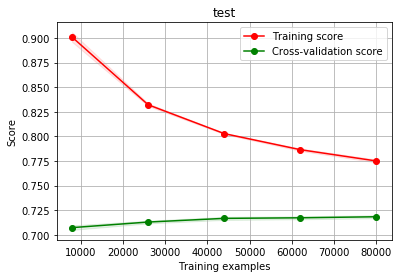

In [569]:
%%time
plot_learning_curve(full_pipeline, 'test', X, y, cv=kfold, n_jobs=1)

In [570]:
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap

In [571]:
perm = PermutationImportance(full_pipeline, random_state=0).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

ValueError: could not convert string to float: 'Grades 3-5'

In [573]:
pdp_tempmax = pdp.pdp_isolate(model=full_pipeline, dataset=X, model_features=X.columns.tolist(), feature='students_reached')
pdp.pdp_plot(pdp_tempmax, 'students_reached')
plt.show()

ValueError: No objects to concatenate

In [572]:
X.columns

Index(['school_metro', 'school_charter', 'school_magnet', 'school_year_round',
       'school_nlns', 'school_kipp', 'school_charter_ready_promise',
       'teacher_prefix', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 'total_price_including_optional_support',
       'year', 'students_reached', 'eligible_double_your_impact_match',
       'eligible_almost_home_match', 'poverty_level', 'grade_level'],
      dtype='object')

# NOTES
- Temporality
- A true train/test split would be 